In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import tree, naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter

# Task 0

In [2]:
def read_documents(doc_file):
    rowNums = []
    docs = []
    labels = []
    with open(doc_file) as f:
        row = 0
        for line in f:
            row+=1
            words = line.strip().split()
            rowNums.append(row)
            docs.append(words[3:])
            labels.append(words[1])
    return rowNums, docs, labels

In [3]:
dataset_name = "dataset"
all_rowNums, all_docs, all_labels = read_documents("{}.txt".format(dataset_name))
#split_point = int(0.80*len(all_docs))
#train_docs = all_docs[:split_point]
#train_labels = all_labels[:split_point]
#eval_docs = all_docs[split_point:]
#eval_labels = all_labels[split_point:]

In [4]:
#or randomly split
train_rows, eval_rows,\
     train_docs, eval_docs,\
     train_labels, eval_labels = sklearn.model_selection.train_test_split(all_rowNums, all_docs, all_labels, test_size=0.2)

In Task 2, we were able to implement the Naive Bayes algorithm that accepts the above structure of train_docs and eval_docs, that is a list of list of strings.<br>
However, sklearn's classifiers require continous numeric values as features, thus we have to convert them to a frequency count matrix.<br>
We used CountVectorizer to achieve this. As a sanity check, we will later test both the manual implementation of Naive Bayes and sklearn's Naive Bayes to see that they are the same.

In [5]:
#first append all word strings into one long document string for each doc
train_strings = [' '.join(doc) for doc in train_docs]
eval_strings = [' '.join(doc) for doc in eval_docs]
#convert training set strings to feature matrix using CountVectorizer
cv = CountVectorizer(token_pattern = r"\S+") #a word is any sequence of non-whitespace characters
cv_train = cv.fit_transform(train_strings)
train_feat = cv_train.toarray()
#only transform and not fit for eval_strings, since want to keep same vocabulary as training
cv_eval = cv.transform(eval_strings)
eval_feat = cv_eval.toarray()

# Task 1

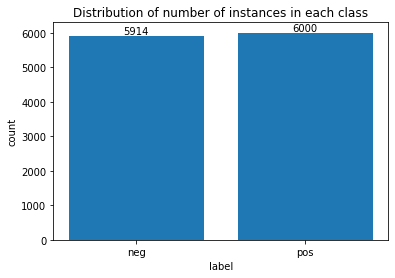

In [6]:
labels_count = np.array([[label, all_labels.count(label)] for label in set(all_labels)])
labels_list = labels_count[:,0]
count_list = labels_count[:,1].astype(np.int)
plt.bar(labels_list, count_list)
plt.xlabel("label")
plt.ylabel("count")
plt.title("Distribution of number of instances in each class")
# display values above bars
for i in range(len(count_list)):
    plt.annotate(str(count_list[i]), xy=(labels_list[i],count_list[i]), ha='center', va='bottom')

# TASK 2
## Naive Bayes
First our manual implementation of Naive Bayes algorithm. 

In [7]:
def train_nb(documents, labels, smooth=0.0):
    """
        Using Naive Bayes Algorithm, computes proabilities of every word given a label, as well as the class proability of label.
        By default, does not apply smoothing.
        returns NB_probs::={<label>: [<label_prob>, <words|label>]}
        where <words|label>::={<word>:<word_freq>}
    """
    NB_probs = dict() #returned dict
    labels_set = set(labels)
    vocabulary = set([j for i in documents for j in i])#flattens documents and keeps unique values
    vocabulary_size = len(vocabulary)

    for label in labels_set:
        #get only documents for given label
        label_docs = [doc for idx,doc in enumerate(documents) if labels[idx]==label]

        words_freq = Counter()
        #first apply smoothing, while also ensuring that every word in vocabulary gets added
        for word in vocabulary:
            words_freq[word]=smooth
        #add frequency of every word in documents of given label
        for doc in label_docs:
            words_freq.update(doc) 
        words_total = sum(words_freq.values()) #total nb of words in documents of given label(smoothing already included)

        #compute P(word|label) for every word in filtered documents
        words_prob = dict()
        for word,freq in words_freq.items():
            words_prob[word] = freq / words_total #smoothing is already applied!
        #compute P(label)
        label_prob = len(label_docs) / len(documents)
        NB_probs[label] = [label_prob, words_prob]
    return NB_probs
    
def test_nb(document, NB_probs):
    """
        Classifies document according to probabilities computed in train_nb()
        Uses log of probabilities to avoid underflow. Ignores words in document that are not part of vocabulary obtained from training
        Returns label with highest probability
    """
    scores = dict()
    for label,(label_prob,words_prob) in NB_probs.items():
        score = np.log(label_prob)
        for word in document:
            if word in words_prob:
                score += np.log(words_prob[word])
        scores[label] = score
    return max(scores, key=scores.get)

In [8]:
NB_probs = train_nb(train_docs, train_labels, 0.5)

In [9]:
count = 0
for doc,label in zip(eval_docs,eval_labels):
    pred = test_nb(doc, NB_probs)
    if pred==label:
        count+=1
manual_nb_accuracy = count / len(eval_docs)

As a sanity check, use sklearn's Naive Bayes and compare accuracies

In [10]:
nb_model = sklearn.naive_bayes.MultinomialNB(alpha=0.5)
nb_model.fit(train_feat, train_labels)
sklearn_nb_accuracy = nb_model.score(eval_feat, eval_labels)

In [11]:
print("Manual NB accuracy:\t{:%}\nSklearn's NB accuracy:\t{:%}".format(manual_nb_accuracy, sklearn_nb_accuracy))

Manual NB accuracy:	79.899287%
Sklearn's NB accuracy:	79.899287%


## Base-DT

In [12]:
base_dt_model = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
base_dt_model.fit(train_feat, train_labels)
base_dt_accuracy = base_dt_model.score(eval_feat, eval_labels)

In [13]:
print("Base-DT accuracy:\t{:%}".format(base_dt_accuracy))

Base-DT accuracy:	69.576164%


## Best-DT
TODO

# Task 3

In [38]:
def test_model(Model, indexes, features, labels, dataset_name):
    """
        Uses provided sklearn Model to generate predictions. Model must have method predict(X)
        Obtains confusion matrix, precision, recall and f1 measure for each class, as well as accuracy.
        Writes results to a file called "[model-name]-[dataset-name].txt"
    """
    model_name = Model.__class__.__name__
    predictions = Model.predict(features)
    accuracy = sklearn.metrics.accuracy_score(labels, predictions)
    confusion_matrix = sklearn.metrics.confusion_matrix(labels, predictions)
    label_names = sorted(set(labels))#sorting because confusion matrix has them in sorted order
    other_stats = []#precision, recall and f1 measure for each class
    for index,row in enumerate(confusion_matrix): #not assuming only 2 labels
        tp = confusion_matrix[index,index] #always along diagonal
        other_indexes = [i for i in range(0, len(label_names)) if i!=index] #list of all other indexes for fp/fn
        fp = np.sum(confusion_matrix[other_indexes, index])
        fn = np.sum(confusion_matrix[index, other_indexes])

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        f1 = (2*precision*recall) / (precision+recall)
        other_stats.append([precision, recall, f1])
    

    #get Pandas dataframe for confusion matrix, as prettier to display in txt file
    labels_true = pd.Series(labels, name='True')
    labels_pred = pd.Series(predictions, name='Predicted')
    confusion_df = pd.crosstab(labels_true, labels_pred)

    #convert label names to indexes in predictions list (don't like it but assignment asks for it..)
    labels_dict = {label: index for index, label in enumerate(label_names)}
    predictions_alt = [labels_dict[label] for label in predictions]

    # write results to new file
    with open("[{}]-[{}].txt".format(model_name, dataset_name), 'w') as f:
        f.write("Accuracy of {}: {:%}\n".format(model_name, accuracy))
        f.write("===== Confusion Matrix =====\n{}\n".format(confusion_df.to_string()))
        f.write("===== Precision/Recall/F1 measure =====\n")
        for label, stats in zip(label_names, other_stats):
            f.write("Label:\t\t {}\nPrecision:\t {:.2%}\nRecall:\t\t {:.2%}\nF1 measure:\t {:.2%}\n\n".format(label, stats[0], stats[1], stats[2]))
        f.write("===== Predictions =====\nLabels to index mapping: {}\n".format(labels_dict))
        for row, pred in sorted(zip(indexes, predictions_alt)):
            f.write("{},{}\n".format(row,pred))
    
    #optional display confusion matrix in notebook
    conf_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=label_names)
    conf_matrix_display.plot()
    plt.title("Confusion Matrix for {}".format(model_name))


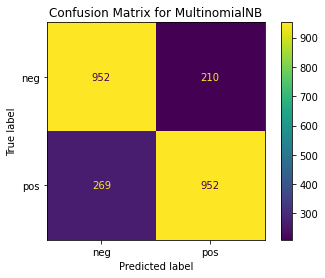

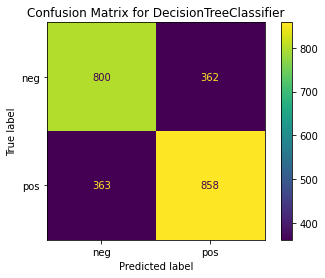

In [39]:
test_model(nb_model, eval_rows, eval_feat, eval_labels, dataset_name)
test_model(base_dt_model, eval_rows, eval_feat, eval_labels, dataset_name)

# Task 4

[1, 0, 0, 1, 1, 0]


# Random stuff, will delete later

In [ ]:
voc1 = set([j for i in train_docs for j in i])#flattens documents and keeps unique values
print(len(voc1))

In [ ]:
voc2 = cv.get_feature_names()
print(len(voc2))

In [ ]:
print(set(voc1)-set(voc2))

In [ ]:
print(set(voc2)-set(voc1))
